# Q1
## Gaussian Processes (GPs) and Stochastic Processes
### • Gaussian Processes (GPs) and Stochastic Processes

- A **stochastic process** is a collection of random variables indexed by time or space. It describes how a random quantity evolves over an input domain. Examples include Markov chains, Brownian motion, and Poisson processes.

- A **Gaussian Process (GP)** is a specific kind of stochastic process where **any finite subset of function values follows a multivariate normal distribution**.

  A GP defines a distribution over functions:
  
  $$
  f(x) \sim \mathcal{GP}(m(x), k(x, x'))
  $$

  where:
  - \( m(x) \) is the **mean function** (often assumed to be zero),
  - \( k(x, x') \) is the **covariance function** (kernel), determining function smoothness and variability.

  GPs are nonparametric Bayesian models, especially useful in **regression, classification, and time-series analysis**, providing flexible uncertainty quantification.

---

### • Variational Inference and ELBO

- **Variational Inference (VI)** is a technique to approximate complex posterior distributions \( p(\theta \mid \mathcal{D}) \) using a simpler family of distributions \( q(\theta) \).

- The goal is to minimize the Kullback-Leibler (KL) divergence between the variational approximation and the true posterior:

  $$
  \text{KL}(q(\theta) \parallel p(\theta \mid \mathcal{D}))
  $$

- This is equivalent to **maximizing the Evidence Lower Bound (ELBO)**:

  $$
  \text{ELBO}(q) = \mathbb{E}_{q(\theta)}[\log p(\mathcal{D}, \theta)] - \mathbb{E}_{q(\theta)}[\log q(\theta)]
  $$

- Maximizing the ELBO improves the approximation \( q(\theta) \), enabling faster and scalable inference compared to traditional MCMC methods.

---

/opt/conda/lib/python3.11/site-packages/pymc/gp/gp.py:56: FutureWarning: The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.
  warnings.warn(_noise_deprecation_warning, FutureWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [length_scale, amplitude, noise]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 36 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [f_pred]


KeyError: 'f_pred'

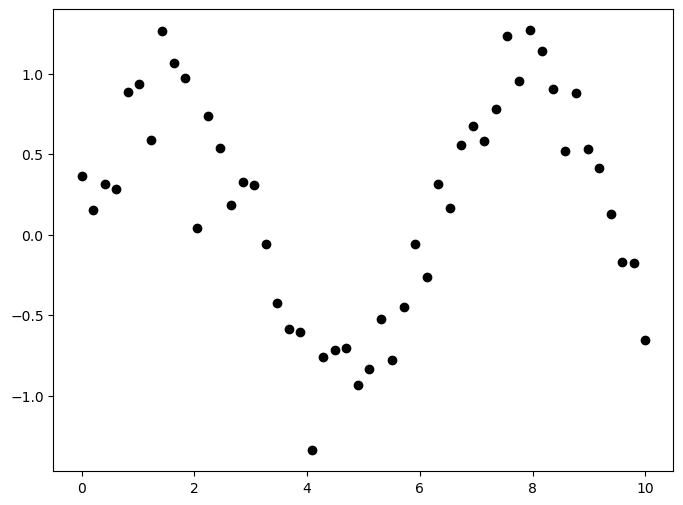

In [4]:
# Q2
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az

# Create synthetic dataset
X = np.linspace(0, 10, 50)[:, None]
y = np.sin(X).ravel() + 0.25 * np.random.randn(50)

with pm.Model() as gp_model:
    
    length_scale = pm.Gamma("length_scale", alpha=2, beta=1)       
    amplitude = pm.HalfNormal("amplitude", sigma=1)                

    kernel = amplitude**2 * pm.gp.cov.ExpQuad(1, length_scale)     

    gp = pm.gp.Marginal(cov_func=kernel)
    noise = pm.HalfNormal("noise", sigma=0.5)

    y_obs = gp.marginal_likelihood("y_obs", X=X, y=y, noise=noise)

    trace = pm.sample(1000, chains=2, progressbar=True)            

X_new = np.linspace(0, 10, 100)[:, None]
with gp_model:
    f_pred = gp.conditional("f_pred", X_new)
    pred_samples = pm.sample_posterior_predictive(trace, var_names=["f_pred"],extend_inferencedata=True)
    
f_samples = pred_samples.posterior_predictive["f_pred"].stack(draws=("chain", "draw")).values


# Plot the results
plt.figure(figsize=(8, 6))                                         
plt.scatter(X, y, color="black", label="Observed Data")
plt.plot(X_new, pred_samples["f_pred"].mean(axis=0), color="blue", label="Posterior Mean")  
plt.fill_between(                                                  
    X_new.ravel(),
    np.percentile(pred_samples["f_pred"], 5, axis=0),
    np.percentile(pred_samples["f_pred"], 95, axis=0),
    color="blue",
    alpha=0.3,
    label="90% Credible Interval"
)
plt.xlabel("Input X")                                              
plt.ylabel("Output y")                                             
plt.title("GP Regression: Posterior Predictive")                   
plt.legend()                                                       
plt.show()


Finished [100%]: Average Loss = 143.84


array([[<Axes: title={'center': 'W1'}>, <Axes: title={'center': 'W1'}>],
       [<Axes: title={'center': 'W2'}>, <Axes: title={'center': 'W2'}>],
       [<Axes: title={'center': 'b1'}>, <Axes: title={'center': 'b1'}>],
       [<Axes: title={'center': 'b2'}>, <Axes: title={'center': 'b2'}>]],
      dtype=object)

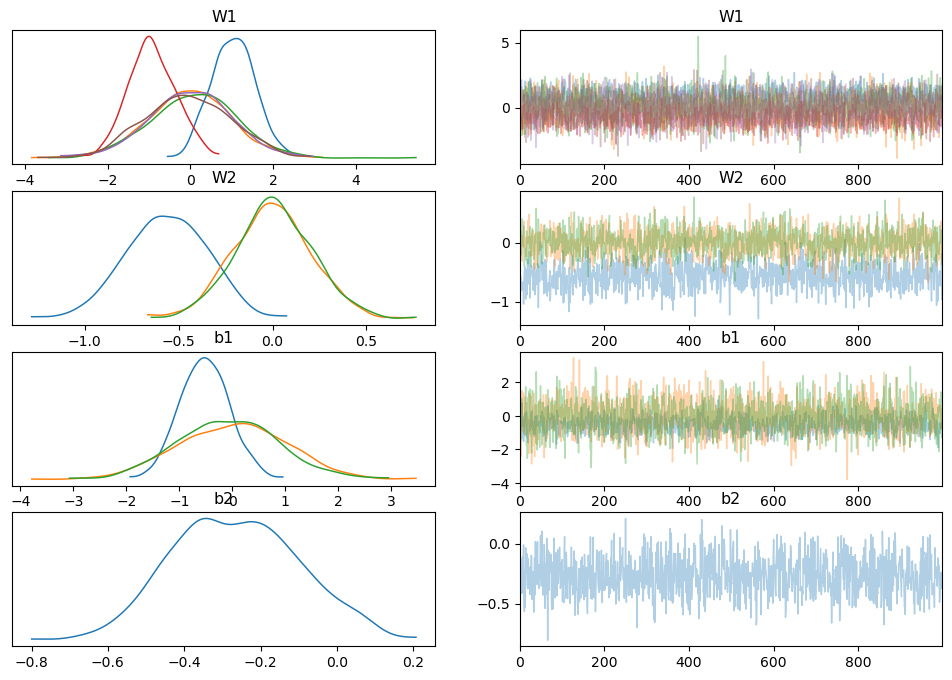

In [8]:
#Q3
import pymc as pm
import numpy as np
import pytensor.tensor as at
import matplotlib.pyplot as plt

np.random.seed(125)
N = 200
X1 = np.random.randn(N, 2)  # 2D input features
true_weights = np.array([1.0, -2.5])
linear_combination = X.dot(true_weights)
p_true = 1 / (1 + np.exp(-linear_combination))
y1 = np.random.binomial(1, p_true)


with pm.Model() as bnn_model:
    n_hidden = 3

    W1 = pm.Normal("W1", mu=0, sigma=1, shape=(2, n_hidden))
    b1 = pm.Normal("b1", mu=0, sigma=1, shape=(n_hidden,))
    
    W2 = pm.Normal("W2", mu=0, sigma=1, shape=(n_hidden,))
    b2 = pm.Normal("b2", mu=0, sigma=1)
    
    hidden_layer = pm.math.tanh(at.dot(X1, W1) + b1)
    logits = at.dot(hidden_layer, W2) + b2
    
    y_obs = pm.Bernoulli("y_obs", logit_p=logits, observed=y1)
    
    
    approx = pm.fit(
        n=5000,
        method="advi",  
        obj_optimizer=pm.adagrad_window(learning_rate=0.01)
    )
    trace = approx.sample(draws=1000)

# 4. Posterior analysis
import arviz as az
az.plot_trace(trace)